In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

directory = "/content/drive/MyDrive/Colab Notebooks/Object Segmentation_UNet/20240612_Dataset/train/images"

# Initialize count
file_count = 0

# Iterate through all files in the directory
for filename in os.listdir(directory):
    if os.path.isfile(os.path.join(directory, filename)):
        file_count += 1

# Print the file count
print("Number of files in directory:", file_count)


Number of files in directory: 204


In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

In [5]:
def load_images_and_masks(image_dir, mask_dir, img_size=(256, 256), image_ext='.jpg', mask_ext='.png'):
    images = []
    masks = []
    image_files = [f for f in os.listdir(image_dir) if f.endswith(image_ext)]

    for image_file in image_files:
        # Load and resize image in grayscale mode
        img_path = os.path.join(image_dir, image_file)
        img = load_img(img_path, target_size=img_size, color_mode="grayscale")
        img = img_to_array(img) / 255.0  # Normalize to [0, 1]
        images.append(img)

        # Create mask file path using the same base name but with different extension
        mask_file = os.path.splitext(image_file)[0] + mask_ext
        mask_path = os.path.join(mask_dir, mask_file)
        if not os.path.exists(mask_path):
            print(f"Mask file not found for {image_file}: expected {mask_path}")
            continue

        # Load and resize mask
        mask = load_img(mask_path, target_size=img_size, color_mode="grayscale")
        mask = img_to_array(mask) / 255.0  # Normalize to [0, 1]
        masks.append(mask)

    return np.array(images), np.array(masks)

In [6]:
def prepare_dataset(img_size=(256, 256)):
    train_images, train_masks = load_images_and_masks(
        '/content/drive/MyDrive/Colab Notebooks/Object Segmentation_UNet/20240612_Dataset/train/images',
        '/content/drive/MyDrive/Colab Notebooks/Object Segmentation_UNet/20240612_Dataset/train/masks',
        img_size,
        image_ext='.jpg',
        mask_ext='.png'
    )
    val_images, val_masks = load_images_and_masks(
        '/content/drive/MyDrive/Colab Notebooks/Object Segmentation_UNet/20240612_Dataset/valid/images',
        '/content/drive/MyDrive/Colab Notebooks/Object Segmentation_UNet/20240612_Dataset/valid/masks',
        img_size,
        image_ext='.jpg',
        mask_ext='.png'
    )
    test_images, test_masks = load_images_and_masks(
        '/content/drive/MyDrive/Colab Notebooks/Object Segmentation_UNet/20240612_Dataset/test/images',
        '/content/drive/MyDrive/Colab Notebooks/Object Segmentation_UNet/20240612_Dataset/test/masks',
        img_size,
        image_ext='.jpg',
        mask_ext='.png'
    )

    # Apply data augmentation to the training set
    #train_images, train_masks = augment_data(train_images, train_masks)

    # Create TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks)).batch(1).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks)).batch(1).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks)).batch(1).prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = prepare_dataset()


In [7]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import binary_crossentropy

def unet_model_modified(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    return model

# Create the modified model
model = unet_model_modified()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint('unet_best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min')

# Assuming train_dataset, val_dataset are already prepared

history = model.fit(train_dataset, validation_data=val_dataset, epochs=100, callbacks=[checkpoint, early_stopping])

Epoch 1/100
203/203 [==============================] - ETA: 0s - loss: 0.5515 - accuracy: 0.7980
Epoch 1: val_loss improved from inf to 0.53299, saving model to unet_best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


203/203 [==============================] - 35s 91ms/step - loss: 0.5515 - accuracy: 0.7980 - val_loss: 0.5330 - val_accuracy: 0.7436
Epoch 2/100
203/203 [==============================] - ETA: 0s - loss: 0.4558 - accuracy: 0.8077
Epoch 2: val_loss improved from 0.53299 to 0.42183, saving model to unet_best_model.h5
203/203 [==============================] - 18s 89ms/step - loss: 0.4558 - accuracy: 0.8077 - val_loss: 0.4218 - val_accuracy: 0.7436
Epoch 3/100
203/203 [==============================] - ETA: 0s - loss: 0.3208 - accuracy: 0.8360
Epoch 3: val_loss improved from 0.42183 to 0.38216, saving model to unet_best_model.h5
203/203 [==============================] - 18s 88ms/step - loss: 0.3208 - accuracy: 0.8360 - val_loss: 0.3822 - val_accuracy: 0.8237
Epoch 4/100
203/203 [==============================] - ETA: 0s - loss: 0.2932 - accuracy: 0.8808
Epoch 4: val_loss improved from 0.38216 to 0.35409, saving model to unet_best_model.h5
203/203 [==============================] - 19s 93

In [9]:
#Save the files to Google Drive
#Restart the session if the code gives an error
%cp -av "/content/unet_best_model.h5" "/content/drive/MyDrive/Colab Notebooks/Object Segmentation_UNet/Trainedmodel/Train04/"

'/content/unet_best_model.h5' -> '/content/drive/MyDrive/Colab Notebooks/Object Segmentation_UNet/Trainedmodel/Train04/unet_best_model.h5'


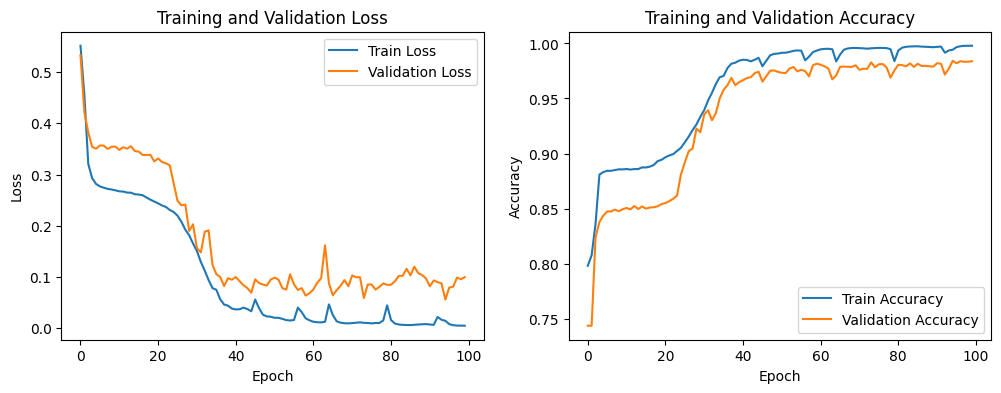

In [10]:
import matplotlib.pyplot as plt
# Plotting training and validation loss and accuracy
def plot_history(history):
    # Loss plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

plot_history(history)


In [11]:
model.load_weights('unet_best_model.h5')
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

7/7 [==============================] - 0s 40ms/step - loss: 0.9704 - accuracy: 0.9204
Test Loss: 0.9704219698905945
Test Accuracy: 0.9204319715499878


In [12]:
from tensorflow.keras import backend as K

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    total = K.sum(y_true_f) + K.sum(y_pred_f)
    union = total - intersection
    return (intersection + smooth) / (union + smooth)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', dice_coefficient, iou])

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function to calculate IoU and Dice Coefficient for binary masks
def calculate_metrics(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    iou = (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)
    return K.eval(dice), K.eval(iou)

# Function to calculate confusion matrix for binary masks
def calculate_confusion_matrix(y_true, y_pred):
    y_true_f = K.flatten(y_true).numpy()
    y_pred_f = K.flatten(y_pred).numpy()
    y_pred_binary = np.where(y_pred_f > 0.5, 1, 0)  # Threshold at 0.5
    cm = confusion_matrix(y_true_f, y_pred_binary)
    return cm

# Evaluate the model on the test dataset
def evaluate_model(model, test_images, test_masks):
    dice_scores = []
    iou_scores = []
    confusion_matrices = []

    for i in range(len(test_images)):
        img = np.expand_dims(test_images[i], axis=0)
        true_mask = np.expand_dims(test_masks[i], axis=0)
        pred_mask = model.predict(img)[0]

        dice, iou = calculate_metrics(true_mask, pred_mask)
        cm = calculate_confusion_matrix(true_mask, pred_mask)

        dice_scores.append(dice)
        iou_scores.append(iou)
        confusion_matrices.append(cm)

    avg_dice = np.mean(dice_scores)
    avg_iou = np.mean(iou_scores)

    return avg_dice, avg_iou, confusion_matrices

In [14]:
# Assuming test_images and test_masks are defined in the global scope
# Load test images and masks
img_size = (256, 256)
test_images, test_masks = load_images_and_masks('/content/drive/MyDrive/Colab Notebooks/Object Segmentation_UNet/20240612_Dataset/test/images', '/content/drive/MyDrive/Colab Notebooks/Object Segmentation_UNet/20240612_Dataset/test/masks', img_size)


1/1 [==============================] - 0s 78ms/step
Average Dice Coefficient: 0.8332348465919495
Average IoU: 0.7283390164375305


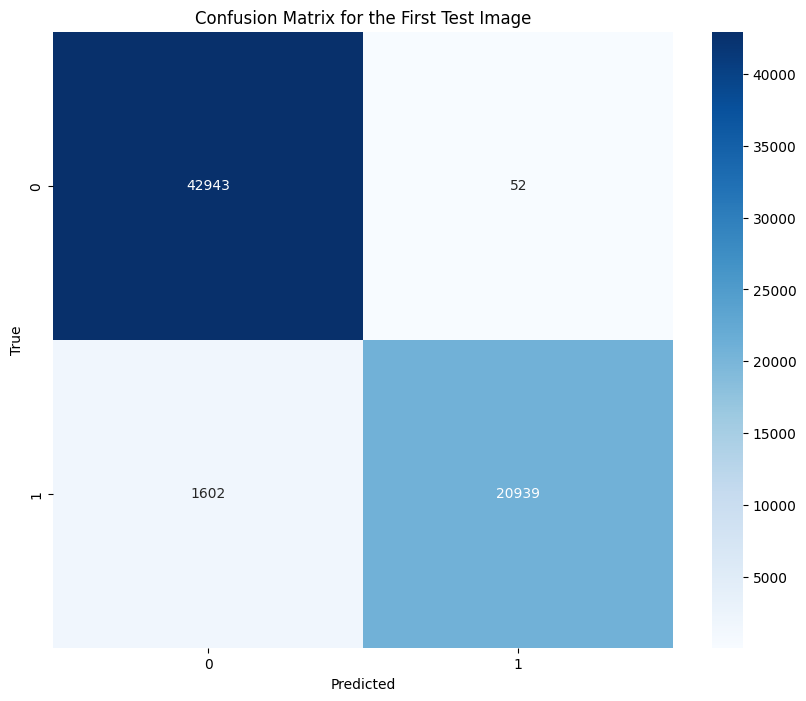

In [15]:
# Evaluate the model
avg_dice, avg_iou, confusion_matrices = evaluate_model(model, test_images, test_masks)

print(f"Average Dice Coefficient: {avg_dice}")
print(f"Average IoU: {avg_iou}")

# Display confusion matrix for the first test image as an example
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrices[0], annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for the First Test Image')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [19]:
# Define the display_predictions function
def display_predictions(test_images, test_masks, model, num_images=None):
    if num_images is None:
        num_images = len(test_images)
    num_images = min(num_images, len(test_images))

    # Ensure predictions are made for the specified number of images
    predictions = model.predict(test_images[:num_images])

    # Set up the figure size dynamically based on the number of images
    plt.figure(figsize=(15, num_images * 5))

    for i in range(num_images):
        # Input Image
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(test_images[i])
        plt.title('Input Image')
        plt.axis('off')

        # True Mask
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(test_masks[i].squeeze(), cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        # Predicted Mask
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Assuming test_images and test_masks are defined and model is loaded
display_predictions(test_images, test_masks, model, num_images=10)

Output hidden; open in https://colab.research.google.com to view.

1/1 [==============================] - 0s 21ms/step


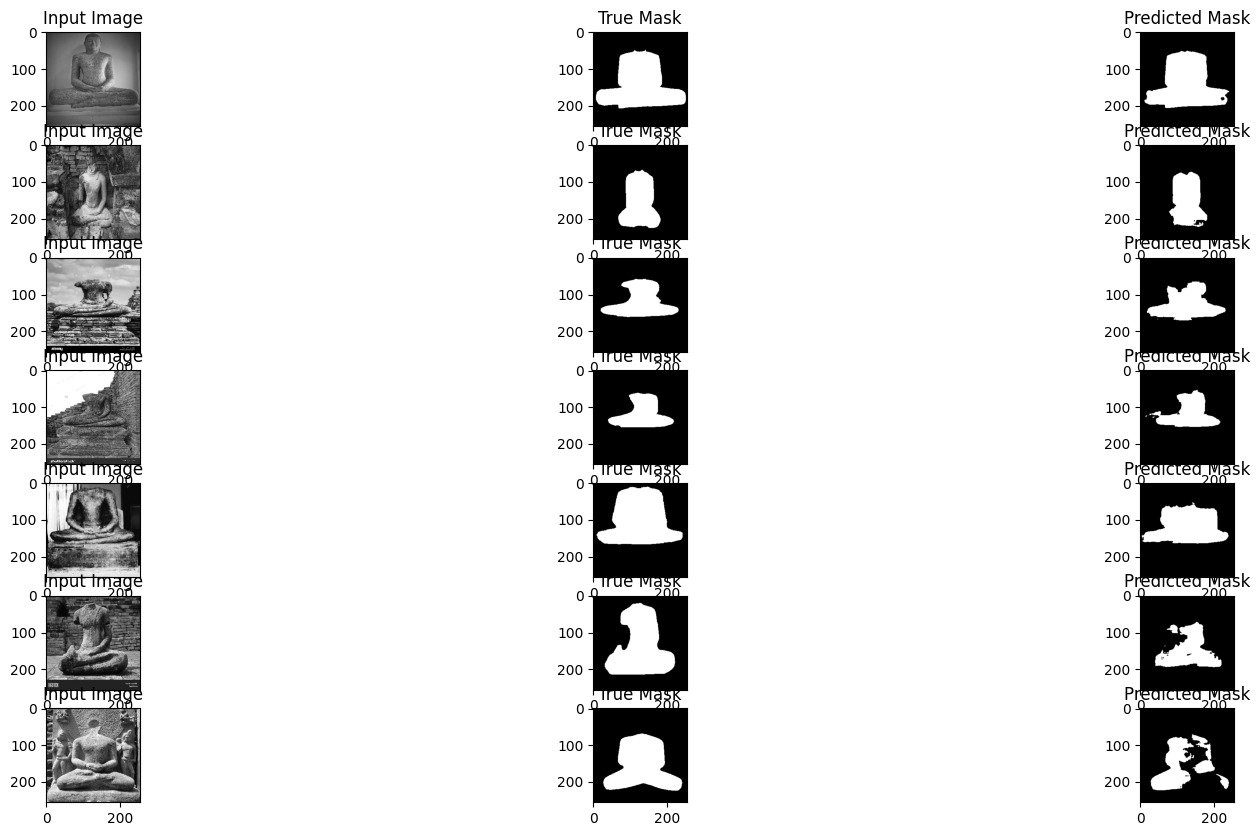

In [20]:
# Define the display_predictions function with thresholding
def display_predictions(test_images, test_masks, model,  num_images = len(test_images), threshold=0.5):
    num_images = min(num_images, len(test_images))
    predictions = model.predict(test_images[:num_images])
    plt.figure(figsize=(20, 10))

    for i in range(num_images):
        plt.subplot(num_images, 3, i*3 + 1)
        plt.imshow(test_images[i].squeeze(), cmap='gray')
        plt.title('Input Image')

        plt.subplot(num_images, 3, i*3 + 2)
        plt.imshow(test_masks[i].squeeze(), cmap='gray')
        plt.title('True Mask')

        # Apply thresholding to the predicted mask
        binary_pred = (predictions[i].squeeze() > threshold).astype(np.uint8)

        plt.subplot(num_images, 3, i*3 + 3)
        plt.imshow(binary_pred, cmap='gray')
        plt.title('Predicted Mask')

    plt.show()

# Display predictions on the test images
display_predictions(test_images, test_masks, model)


1/1 [==============================] - 5s 5s/step


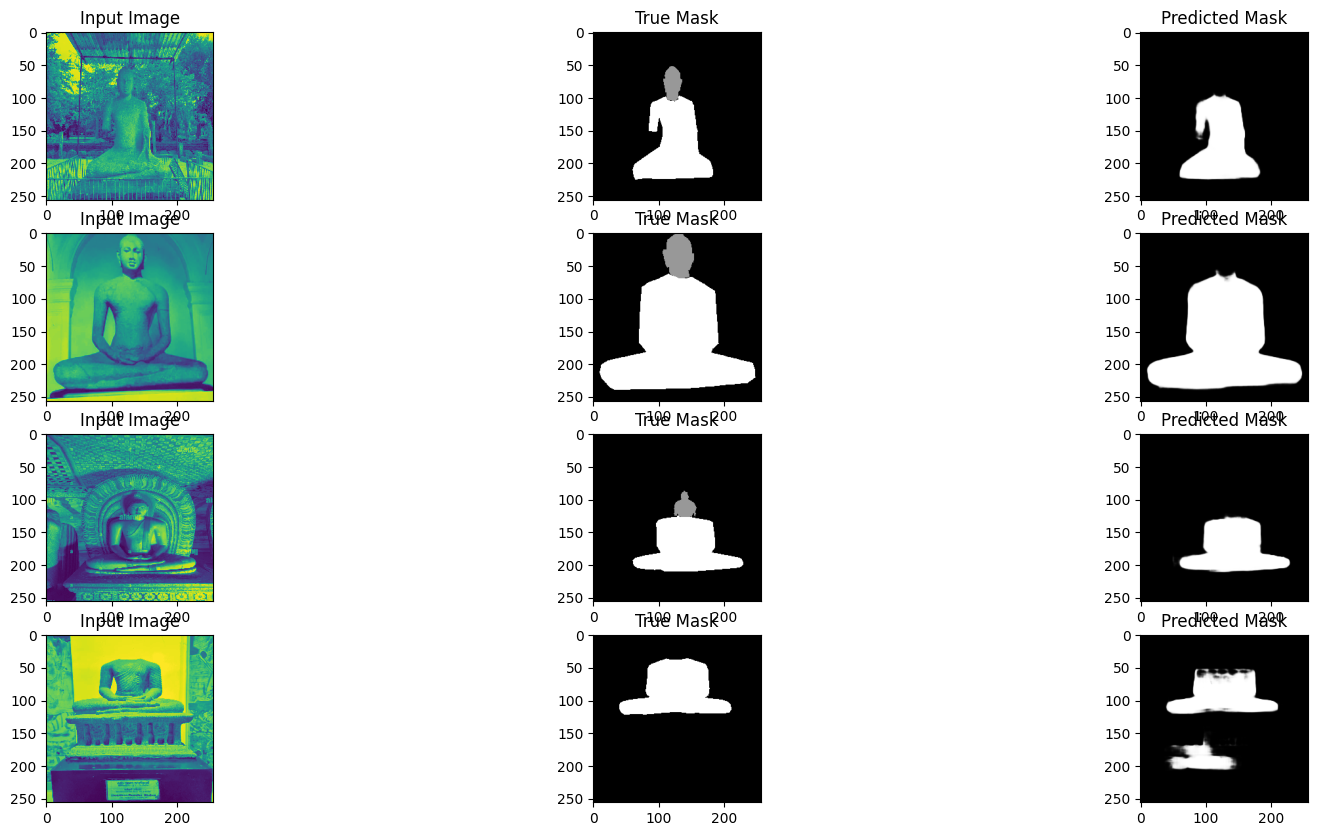

In [21]:
# Assuming test_images and test_masks are defined in the global scope
# Load test images and masks
img_size = (256, 256)
test_images, test_masks = load_images_and_masks('/content/drive/MyDrive/Colab Notebooks/Object Segmentation_UNet/dataset/test/images', '/content/drive/MyDrive/Colab Notebooks/Object Segmentation_UNet/dataset/test/masks', img_size)

# Define the display_predictions function
def display_predictions(test_images, test_masks, model,  num_images = len(test_images)):
    num_images = min(num_images, len(test_images))
    predictions = model.predict(test_images[:num_images])
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(num_images, 3, i*3 + 1)
        plt.imshow(test_images[i])
        plt.title('Input Image')
        plt.subplot(num_images, 3, i*3 + 2)
        plt.imshow(test_masks[i].squeeze(), cmap='gray')
        plt.title('True Mask')
        plt.subplot(num_images, 3, i*3 + 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
    plt.show()

display_predictions(test_images, test_masks, model)

1/1 [==============================] - 0s 21ms/step


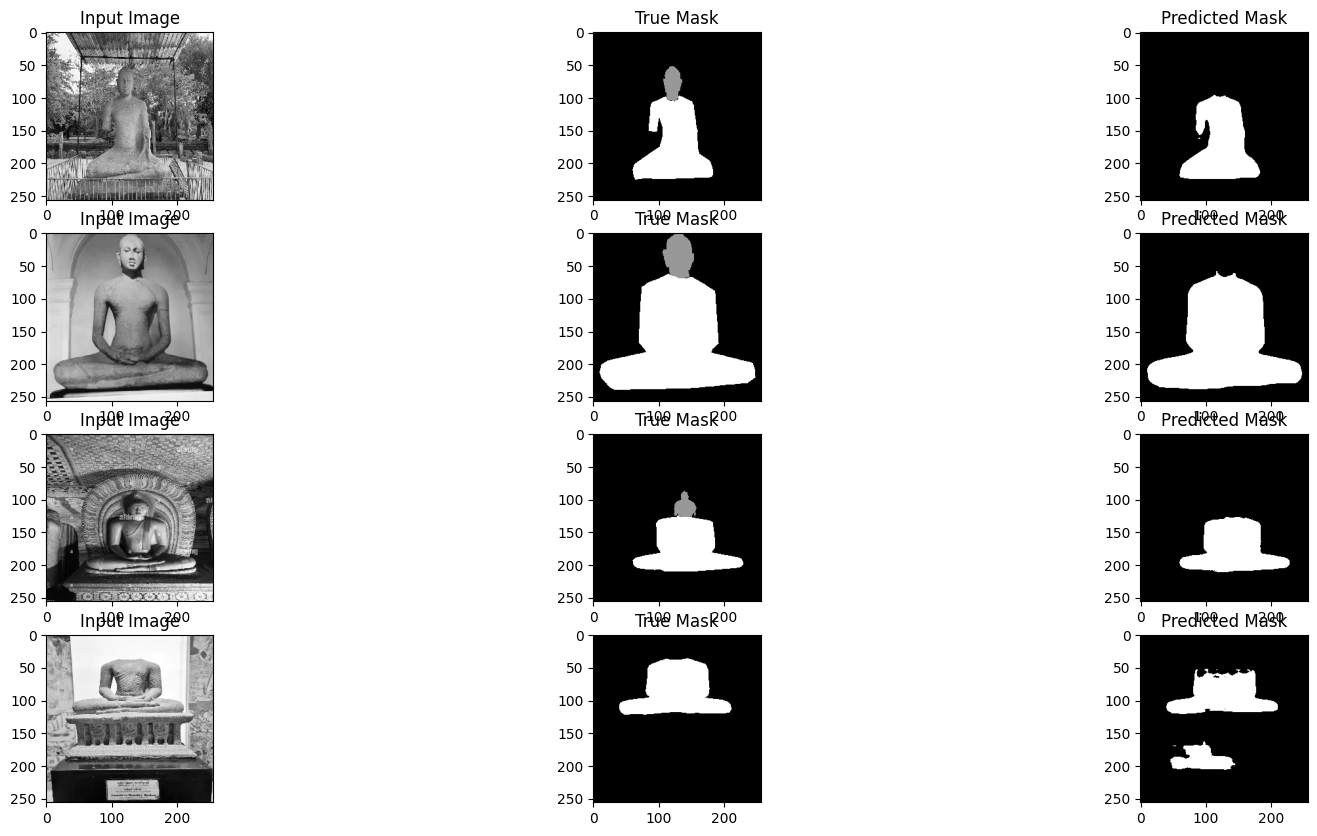

In [22]:
# Define the display_predictions function with thresholding
def display_predictions(test_images, test_masks, model, num_images=5, threshold=0.5):
    num_images = min(num_images, len(test_images))
    predictions = model.predict(test_images[:num_images])
    plt.figure(figsize=(20, 10))

    for i in range(num_images):
        plt.subplot(num_images, 3, i*3 + 1)
        plt.imshow(test_images[i].squeeze(), cmap='gray')
        plt.title('Input Image')

        plt.subplot(num_images, 3, i*3 + 2)
        plt.imshow(test_masks[i].squeeze(), cmap='gray')
        plt.title('True Mask')

        # Apply thresholding to the predicted mask
        binary_pred = (predictions[i].squeeze() > threshold).astype(np.uint8)

        plt.subplot(num_images, 3, i*3 + 3)
        plt.imshow(binary_pred, cmap='gray')
        plt.title('Predicted Mask')

    plt.show()

# Load test images and masks
img_size = (256, 256)
test_images, test_masks = load_images_and_masks(
    '/content/drive/MyDrive/Colab Notebooks/Object Segmentation_UNet/dataset/test/images',
    '/content/drive/MyDrive/Colab Notebooks/Object Segmentation_UNet/dataset/test/masks',
    img_size
)

# Display predictions on the test images
display_predictions(test_images, test_masks, model)


1/1 [==============================] - 0s 20ms/step


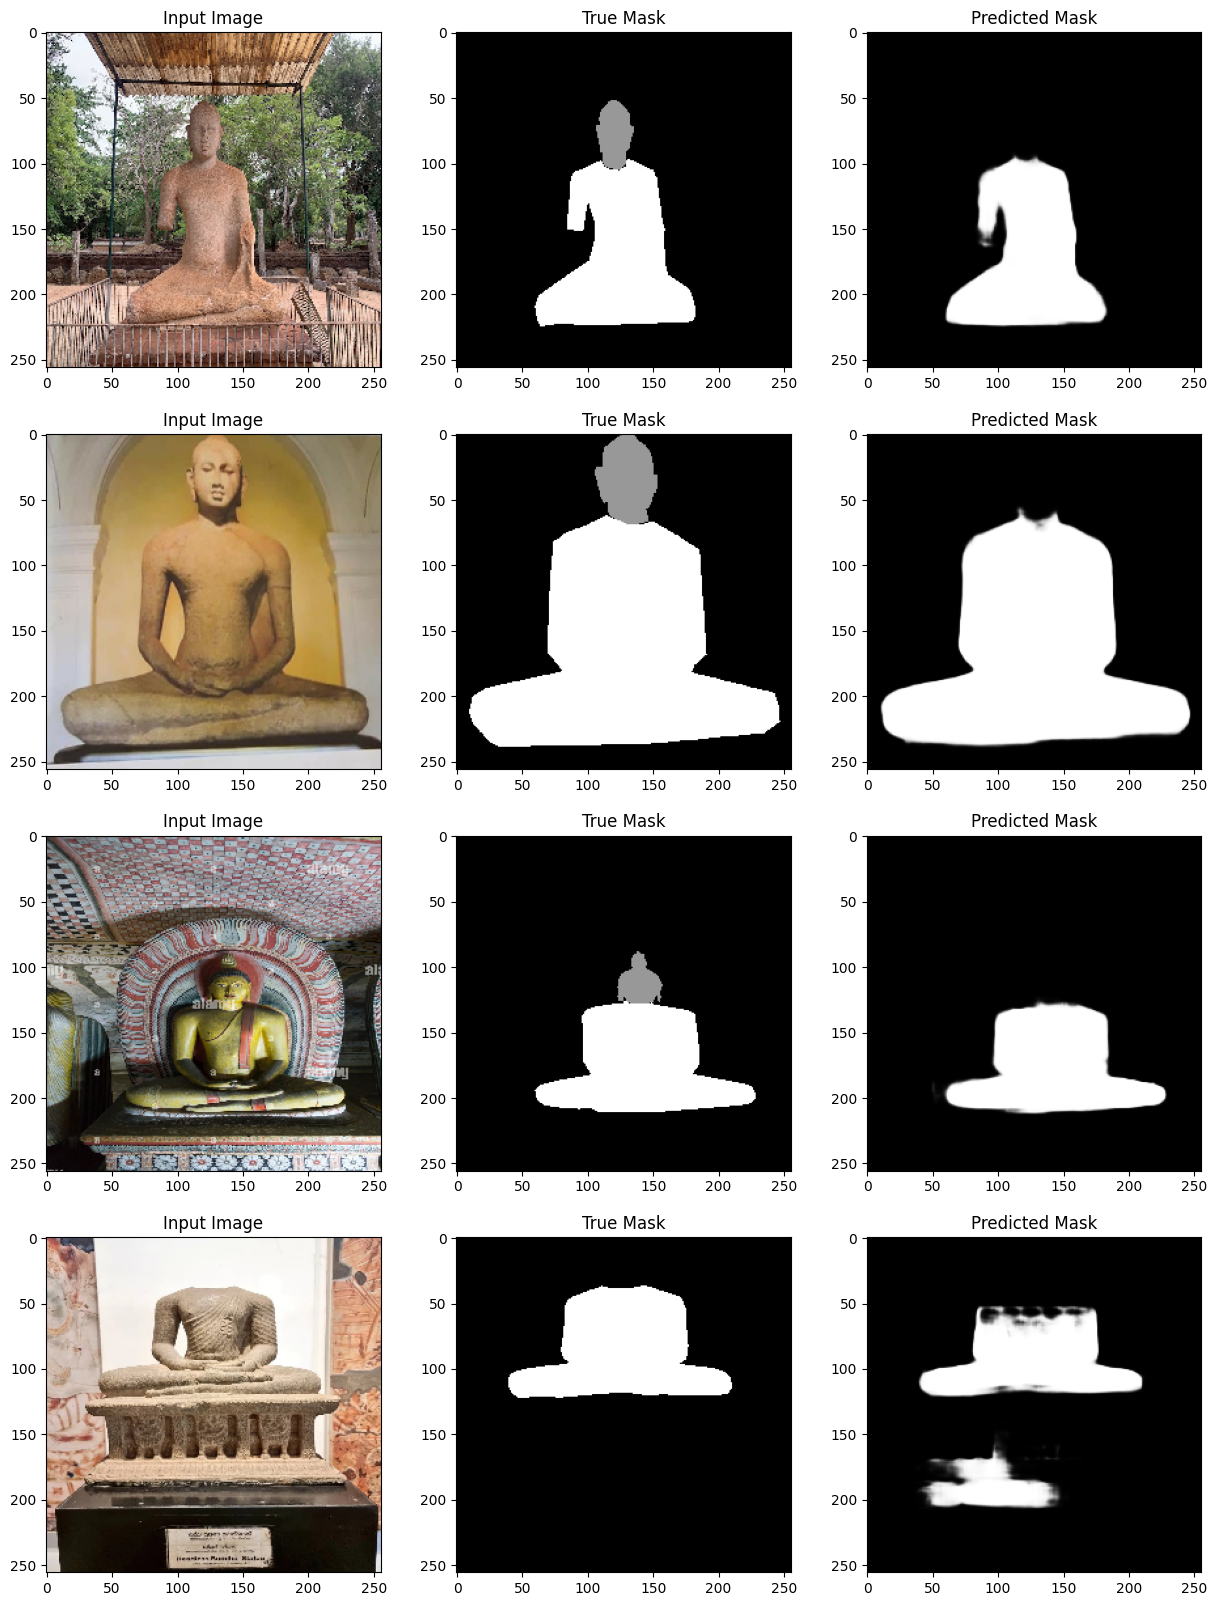

In [23]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os

# Load test images and masks for model input
img_size = (256, 256)
test_images, test_masks = load_images_and_masks(
    '/content/drive/MyDrive/Colab Notebooks/Object Segmentation_UNet/dataset/test/images',
    '/content/drive/MyDrive/Colab Notebooks/Object Segmentation_UNet/dataset/test/masks',
    img_size
)

# Function to load original images in color
def load_original_images(image_dir, img_size=(256, 256), image_ext='.jpg'):
    images = []
    image_files = [f for f in os.listdir(image_dir) if f.endswith(image_ext)]
    for image_file in image_files:
        img_path = os.path.join(image_dir, image_file)
        img = load_img(img_path, target_size=img_size, color_mode="rgb")
        img = img_to_array(img) / 255.0  # Normalize to [0, 1]
        images.append(img)
    return np.array(images)

# Load the original color images for display
original_test_images = load_original_images('/content/drive/MyDrive/Colab Notebooks/Object Segmentation_UNet/dataset/test/images', img_size)

# Define the display_predictions function
def display_predictions(original_images, test_images, test_masks, model, num_images=5):
    num_images = min(num_images, len(test_images))
    predictions = model.predict(test_images[:num_images])
    plt.figure(figsize=(15, num_images * 5))
    for i in range(num_images):
        plt.subplot(num_images, 3, i*3 + 1)
        plt.imshow(original_images[i])
        plt.title('Input Image')
        plt.subplot(num_images, 3, i*3 + 2)
        plt.imshow(test_masks[i].squeeze(), cmap='gray')
        plt.title('True Mask')
        plt.subplot(num_images, 3, i*3 + 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
    plt.show()

# Load the model with the best weights
model.load_weights('unet_best_model.h5')

# Display predictions on the test images
display_predictions(original_test_images, test_images, test_masks, model)


1/1 [==============================] - 0s 21ms/step


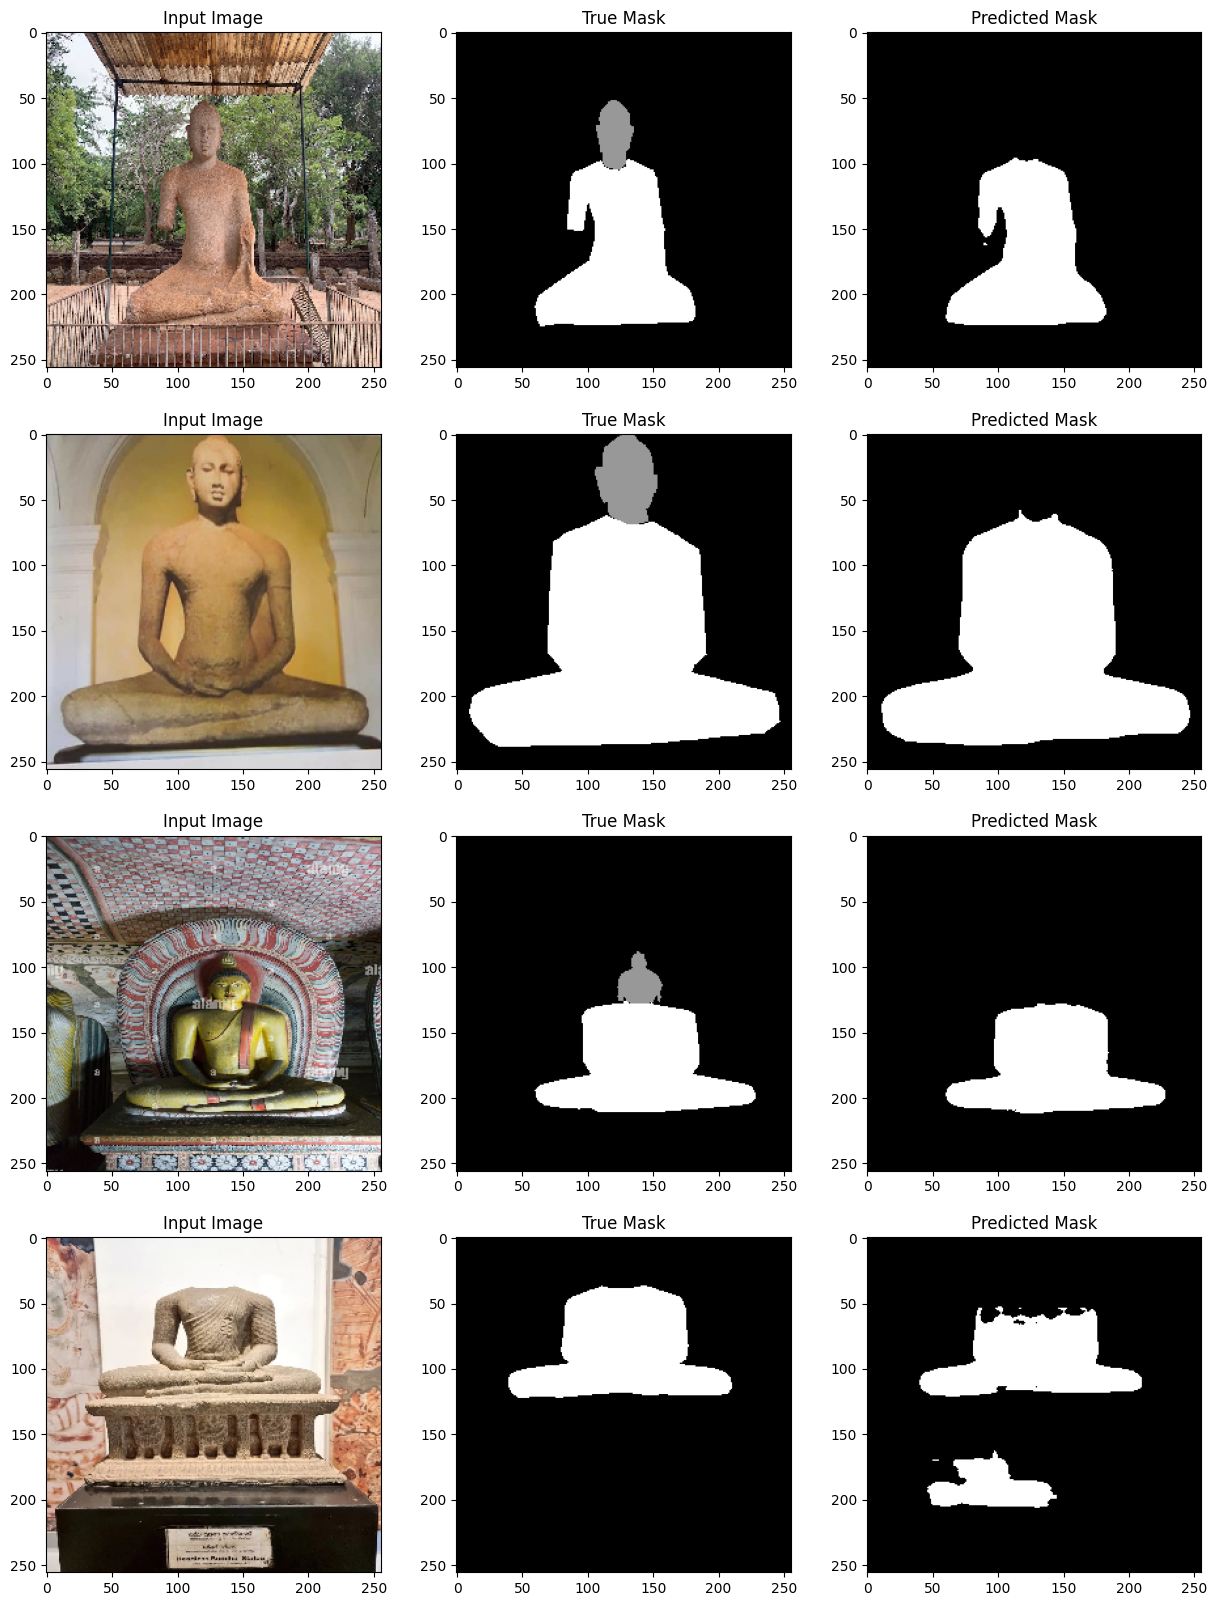

In [24]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os

# Load test images and masks for model input
img_size = (256, 256)
test_images, test_masks = load_images_and_masks(
    '/content/drive/MyDrive/Colab Notebooks/Object Segmentation_UNet/dataset/test/images',
    '/content/drive/MyDrive/Colab Notebooks/Object Segmentation_UNet/dataset/test/masks',
    img_size
)

# Function to load original images in color
def load_original_images(image_dir, img_size=(256, 256), image_ext='.jpg'):
    images = []
    image_files = [f for f in os.listdir(image_dir) if f.endswith(image_ext)]
    for image_file in image_files:
        img_path = os.path.join(image_dir, image_file)
        img = load_img(img_path, target_size=img_size, color_mode="rgb")
        img = img_to_array(img) / 255.0  # Normalize to [0, 1]
        images.append(img)
    return np.array(images)

# Load the original color images for display
original_test_images = load_original_images('/content/drive/MyDrive/Colab Notebooks/Object Segmentation_UNet/dataset/test/images', img_size)

# Define the display_predictions function with thresholding
def display_predictions(original_images, test_images, test_masks, model, num_images=5, threshold=0.5):
    num_images = min(num_images, len(test_images))
    predictions = model.predict(test_images[:num_images])
    plt.figure(figsize=(15, num_images * 5))

    for i in range(num_images):
        plt.subplot(num_images, 3, i*3 + 1)
        plt.imshow(original_images[i])
        plt.title('Input Image')

        plt.subplot(num_images, 3, i*3 + 2)
        plt.imshow(test_masks[i].squeeze(), cmap='gray')
        plt.title('True Mask')

        # Apply thresholding to the predicted mask
        binary_pred = (predictions[i].squeeze() > threshold).astype(np.uint8)

        plt.subplot(num_images, 3, i*3 + 3)
        plt.imshow(binary_pred, cmap='gray')
        plt.title('Predicted Mask')

    plt.show()

# Load the model with the best weights
model.load_weights('unet_best_model.h5')

# Display predictions on the test images
display_predictions(original_test_images, test_images, test_masks, model)


1/1 [==============================] - 0s 30ms/step


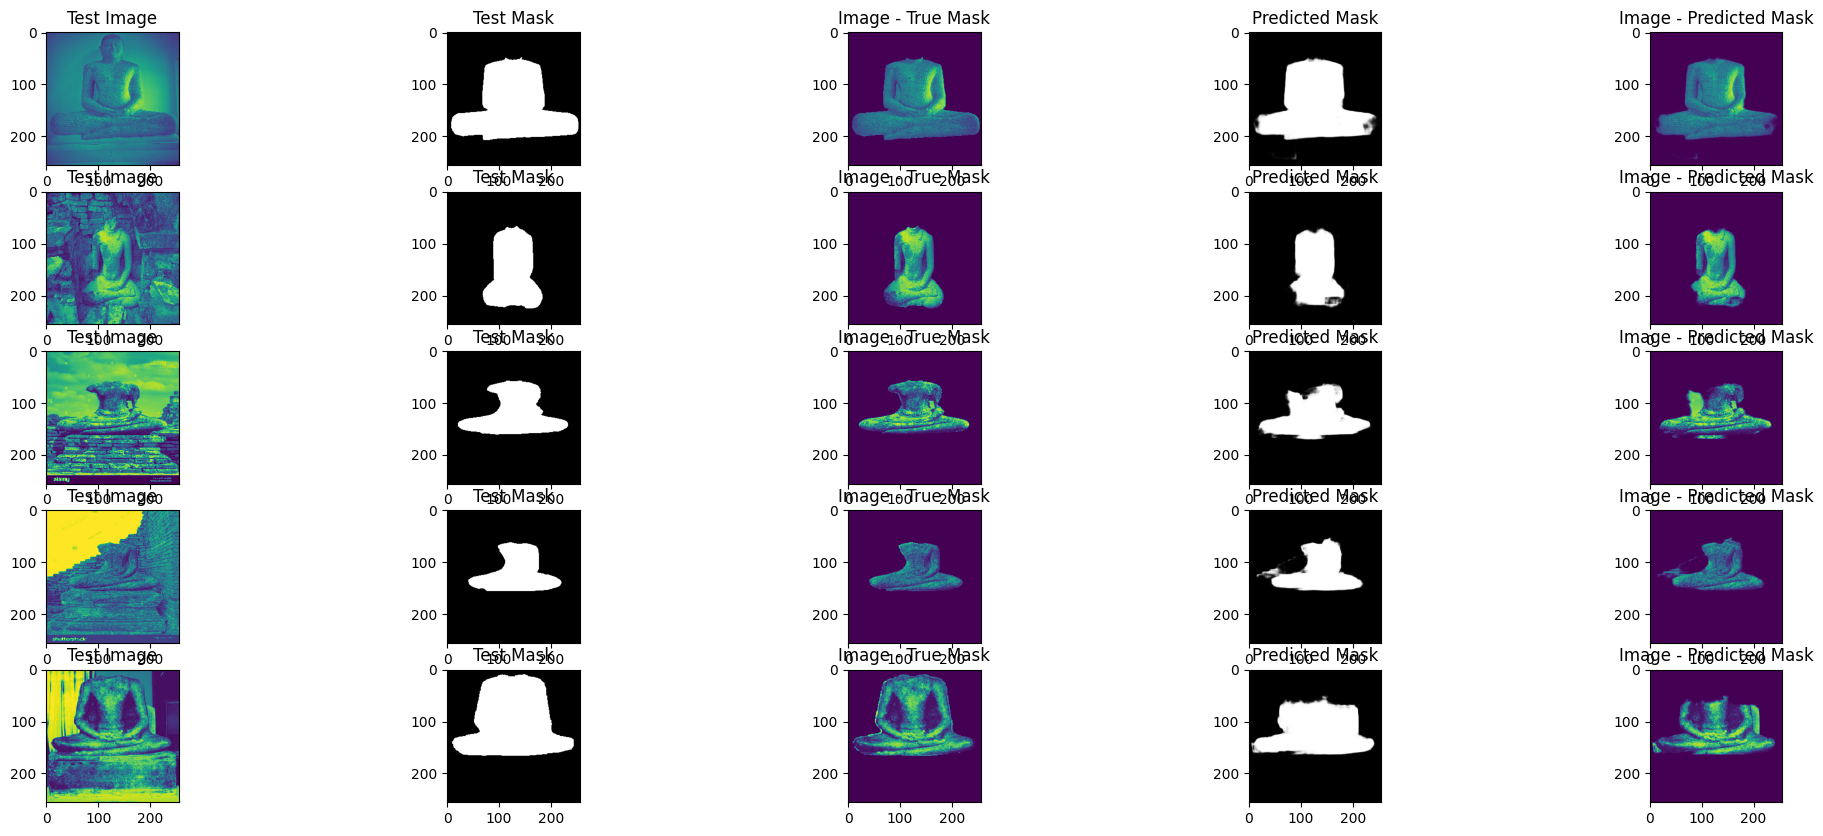

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming test_images and test_masks are defined in the global scope
# Load test images and masks
img_size = (256, 256)
test_images, test_masks = load_images_and_masks('/content/drive/MyDrive/Colab Notebooks/Object Segmentation_UNet/20240612_Dataset/test/images', '/content/drive/MyDrive/Colab Notebooks/Object Segmentation_UNet/20240612_Dataset/test/masks', img_size)

# Define the display_predictions function
def display_predictions(test_images, test_masks, model, num_images=5):
    num_images = min(num_images, len(test_images))
    predictions = model.predict(test_images[:num_images])
    plt.figure(figsize=(25, 10))

    for i in range(num_images):
        # Display the test image
        plt.subplot(num_images, 5, i*5 + 1)
        plt.imshow(test_images[i])
        plt.title('Test Image')

        # Display the test mask
        plt.subplot(num_images, 5, i*5 + 2)
        plt.imshow(test_masks[i].squeeze(), cmap='gray')
        plt.title('Test Mask')

        # Display the test image subtracted from the test mask
        masked_image = test_images[i] * test_masks[i]
        plt.subplot(num_images, 5, i*5 + 3)
        plt.imshow(masked_image)
        plt.title('Image - True Mask')

        # Display the predicted mask
        plt.subplot(num_images, 5, i*5 + 4)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')

        # Display the test image subtracted from the predicted mask
        predicted_masked_image = test_images[i] * predictions[i]
        plt.subplot(num_images, 5, i*5 + 5)
        plt.imshow(predicted_masked_image)
        plt.title('Image - Predicted Mask')

    plt.show()

display_predictions(test_images, test_masks, model)


In [32]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os

# Function to load original images in color
def load_original_images(image_dir, img_size=(256, 256), image_ext='.jpg'):
    images = []
    image_files = [f for f in os.listdir(image_dir) if f.endswith(image_ext)]
    for image_file in image_files:
        img_path = os.path.join(image_dir, image_file)
        img = load_img(img_path, target_size=img_size, color_mode="rgb")
        img = img_to_array(img) / 255.0  # Normalize to [0, 1]
        images.append(img)
    return np.array(images)

# Function to calculate IoU
def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

# Function to calculate Dice Coefficient
def calculate_dice(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    dice_score = (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))
    return dice_score

# Define the display_predictions function with IoU and Dice calculations
def display_predictions(original_images, test_images, test_masks, model, num_images=10, threshold=0.5):
    num_images = min(num_images, len(test_images))
    predictions = model.predict(test_images[:num_images])
    plt.figure(figsize=(25, num_images * 5))

    for i in range(num_images):
        # Display the test image
        plt.subplot(num_images, 5, i*5 + 1)
        plt.imshow(original_images[i])
        plt.title('Test Image')

        # Display the test mask
        plt.subplot(num_images, 5, i*5 + 2)
        plt.imshow(test_masks[i].squeeze(), cmap='gray')
        plt.title('Test Mask')

        # Display the test image with true mask overlay
        masked_image = original_images[i] * np.repeat(test_masks[i], 3, axis=-1)
        plt.subplot(num_images, 5, i*5 + 3)
        plt.imshow(masked_image)
        plt.title('Image - True Mask')

        # Apply thresholding to the predicted mask
        binary_pred = (predictions[i].squeeze() > threshold).astype(np.uint8)

        # Display the predicted mask
        plt.subplot(num_images, 5, i*5 + 4)
        plt.imshow(binary_pred, cmap='gray')
        plt.title('Predicted Mask')

        # Display the test image with predicted mask overlay
        predicted_masked_image = original_images[i] * np.repeat(binary_pred[..., np.newaxis], 3, axis=-1)
        plt.subplot(num_images, 5, i*5 + 5)
        plt.imshow(predicted_masked_image)
        plt.title('Image - Predicted Mask')

        # Calculate IoU and Dice
        iou_score = calculate_iou(test_masks[i].squeeze(), binary_pred)
        dice_score = calculate_dice(test_masks[i].squeeze(), binary_pred)
        print(f"Image {i+1} - IoU: {iou_score:.4f}, Dice Coefficient: {dice_score:.4f}")

    plt.show()

# Load test images and masks for model input
img_size = (256, 256)
test_images, test_masks = load_images_and_masks(
    '/content/drive/MyDrive/Colab Notebooks/Object Segmentation_UNet/20240612_Dataset/test/images',
    '/content/drive/MyDrive/Colab Notebooks/Object Segmentation_UNet/20240612_Dataset/test/masks',
    img_size
)

# Load the original color images for display
original_test_images = load_original_images('/content/drive/MyDrive/Colab Notebooks/Object Segmentation_UNet/20240612_Dataset/test/images', img_size)

# Load the model with the best weights
model.load_weights('unet_best_model.h5')

# Display predictions on the test images
display_predictions(original_test_images, test_images, test_masks, model)


Output hidden; open in https://colab.research.google.com to view.